# Exploratory analysis and proof of concept

Proof of concept for csv files - transformed from JSON files from the mining pool
Functionality:
- load text files
- calculate max, min, mean
- create plot and send it via email

config.py file is required an being present in the same folder as this notebook

In [1]:
#import os
#import sys
#import logging
#from pathlib import Path


import pandas as pd
import glob
#from pathlib import Path
#import os.path
#import sys
import matplotlib.pyplot as plt
import io
from email.mime.multipart import MIMEMultipart
from email.mime.base import MIMEBase
from email import encoders
from email.mime.text import MIMEText

import config

In [2]:
# get source path and mask
inputDir = config.sourceFiles

In [3]:
df = pd.concat([pd.read_csv(f) for f in glob.glob(inputDir)], ignore_index = True)
#df.info()
#df.head

In [4]:
df['reportedHashrate'] = df['reportedHashrate']/1000/1000
df['currentHashrate'] = df['currentHashrate']/1000/1000
df['averageHashrate'] = df['currentHashrate'].mean()

df = df.drop_duplicates(keep='first')
df['ts'] = pd.to_datetime(df['time'],unit='s')
#df

# Plot a sinple chart

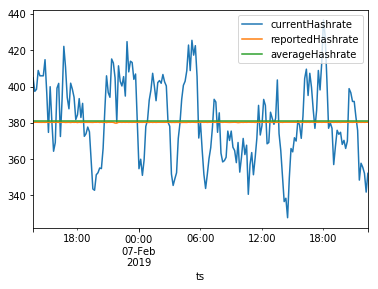

In [5]:
df=df.sort_values(by=['ts'])
df.plot(x='ts', y=['currentHashrate','reportedHashrate','averageHashrate'])
plt.show()

In [6]:
# Absolute difference between min and max shouldn't be more than 5Mh, ideally not more than 2
reportedMh = df['reportedHashrate']
abs(reportedMh.max() - reportedMh.min())


# shouldn't fall bellow 360
averageMh = df['currentHashrate'].mean()

{}

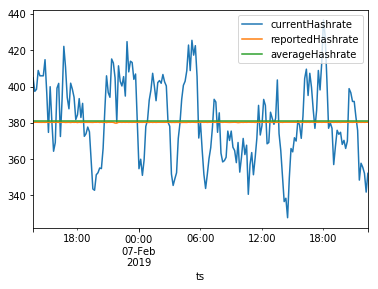

In [7]:
# humbly inspired by https://fusioncell.ai/python3-email-with-attachments-using-gmail/
import smtplib

server = smtplib.SMTP('smtp.gmail.com', 587)
server.starttls()
server.login(config.smtpUser, config.smtpPasswd)

# Preparing message

## Plot attachement
buf = io.BytesIO()
df.plot(x='ts', y=['currentHashrate','reportedHashrate','averageHashrate'])
plt.savefig(buf, format = 'png')
buf.seek(0)

## Mail body
mail = MIMEMultipart()
mail['Subject'] = 'Miner Alert'
mail['To'] = config.recipients
mail['From'] = config.sender
mail.preamble = 'You will not see this in a MIME-aware mail reader.\n'

part = MIMEBase('application', "octet-stream")
part.set_payload( buf.read() )
encoders.encode_base64(part)
part.add_header('Content-Disposition', 'attachment; filename="%s"' % 'anything.png')

mail.attach(part)

messageText = f"""Hey, something fishy is happening with mining machines.
Min reported hashrate: {reportedMh.min()}
Max reported hashrate: {reportedMh.max()}
Average hashrate: {averageMh}"""

email_text = MIMEText(messageText, 'plain')
mail.attach(email_text)

# Send the mail
server.sendmail(config.sender, config.recipients, mail.as_string())